# Heart Disease: Classification of Heart Disease Patients in Cleveland using Age, Cholestoral, and Heart Rate

#### Sophia Yang

### Introduction
Heart Disease, or Cardiovascular Disease, include various conditions that affect the heart. Many of these conditions are caused by atherosclerosis, a condition that develops when a buildup of plaque occurs along the walls of the arteries, causing them to narrow. This makes it harder for blood to flow, and can cause a heart attack or stroke if a blood clot forms and blocks the artery.


Common heart diseases include:
- Heart attack
- Stroke
- Heart failure
- Arrythmia
- Blood vessel disease
- Heart valve disease

Studies have shown that higher levels of LDL cholerstorals creates a larger risk of heart disease at a younger age. High levels LDL cholestorals, or 'bad' cholestorals can form plaque or fatty deposits that can block blood flow. Additionally, a high heart rate can also be an indicator for heart disease, although heart rate levels do tend to lower as you age.

### UCl Heart Disease Dataset
The dataset used for this project will be the [UCl Heart Disease Dataset](https://archive.ics.uci.edu/dataset/45/heart+disease) reported by UC Irvine. The database separate data files based on four different locations (Cleveland, Hungary, Switzerland, and the VA Long Beach), but we will be focusing on the dataset for Cleveland. The dataset contains 303 observations, and 14 relavant variables. However, we will only be focusing on 4 variables for this project (refer to Methods).


### Preliminary Data Analysis

#### Reading Data and Setting Variables


In [95]:
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)
library(cowplot)


data_url <- "https://raw.githubusercontent.com/sophiaxsyang/dsci100-prject/main/processed.cleveland.data"

cleveland_data_raw <- read_csv(data_url,
                           col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                                         "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"),
                           col_types = list("d", "f", "f", "d", "d", "f", "f", "d", "f", "d", "f", "d", "f", "d"))
head(cleveland_data_raw)

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>
63,1.0,1.0,145,233,1.0,2.0,150,0.0,2.3,3.0,0,6.0,0
67,1.0,4.0,160,286,0.0,2.0,108,1.0,1.5,2.0,3,3.0,2
67,1.0,4.0,120,229,0.0,2.0,129,1.0,2.6,2.0,2,7.0,1
37,1.0,3.0,130,250,0.0,0.0,187,0.0,3.5,3.0,0,3.0,0
41,0.0,2.0,130,204,0.0,2.0,172,0.0,1.4,1.0,0,3.0,0
56,1.0,2.0,120,236,0.0,0.0,178,0.0,0.8,1.0,0,3.0,0


[1] 303

#### Tidying Data

In [96]:
set.seed(1)
cleveland_data <- cleveland_data_raw |>
    select(age, chol, thalach, num) |>
    mutate(diagnosis = ifelse((num > 0), TRUE, FALSE)) 


# Split the dataset into training and testing sets.
cleveland_split <- initial_split(cleveland_data, prop = 3/4, strata = num)
cleveland_training_data <- training(cleveland_split)
cleveland_testing_data <- testing(cleveland_split)

head(cleveland_training_data)

age,chol,thalach,num,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
63,233,150,0,FALSE
41,204,172,0,FALSE
56,294,153,0,FALSE
57,168,174,0,FALSE
49,266,171,0,FALSE
64,211,144,0,FALSE


In [97]:
# Grouping by diagnosis, then summarize to calculate the mean for each predictor and count
cleveland_summarize <- cleveland_training_data |>
                    group_by(diagnosis) |>
                    summarize(mean_age = mean(age),
                              mean_chol = mean(chol), 
                              mean_thalach = mean(thalach),
                              count = n())

cleveland_summarize

diagnosis,mean_age,mean_chol,mean_thalach,count
<lgl>,<dbl>,<dbl>,<dbl>,<int>
FALSE,52.68548,244.2903,158.9194,124
TRUE,56.48039,249.3627,138.4118,102


### Preliminiary Data Visualization

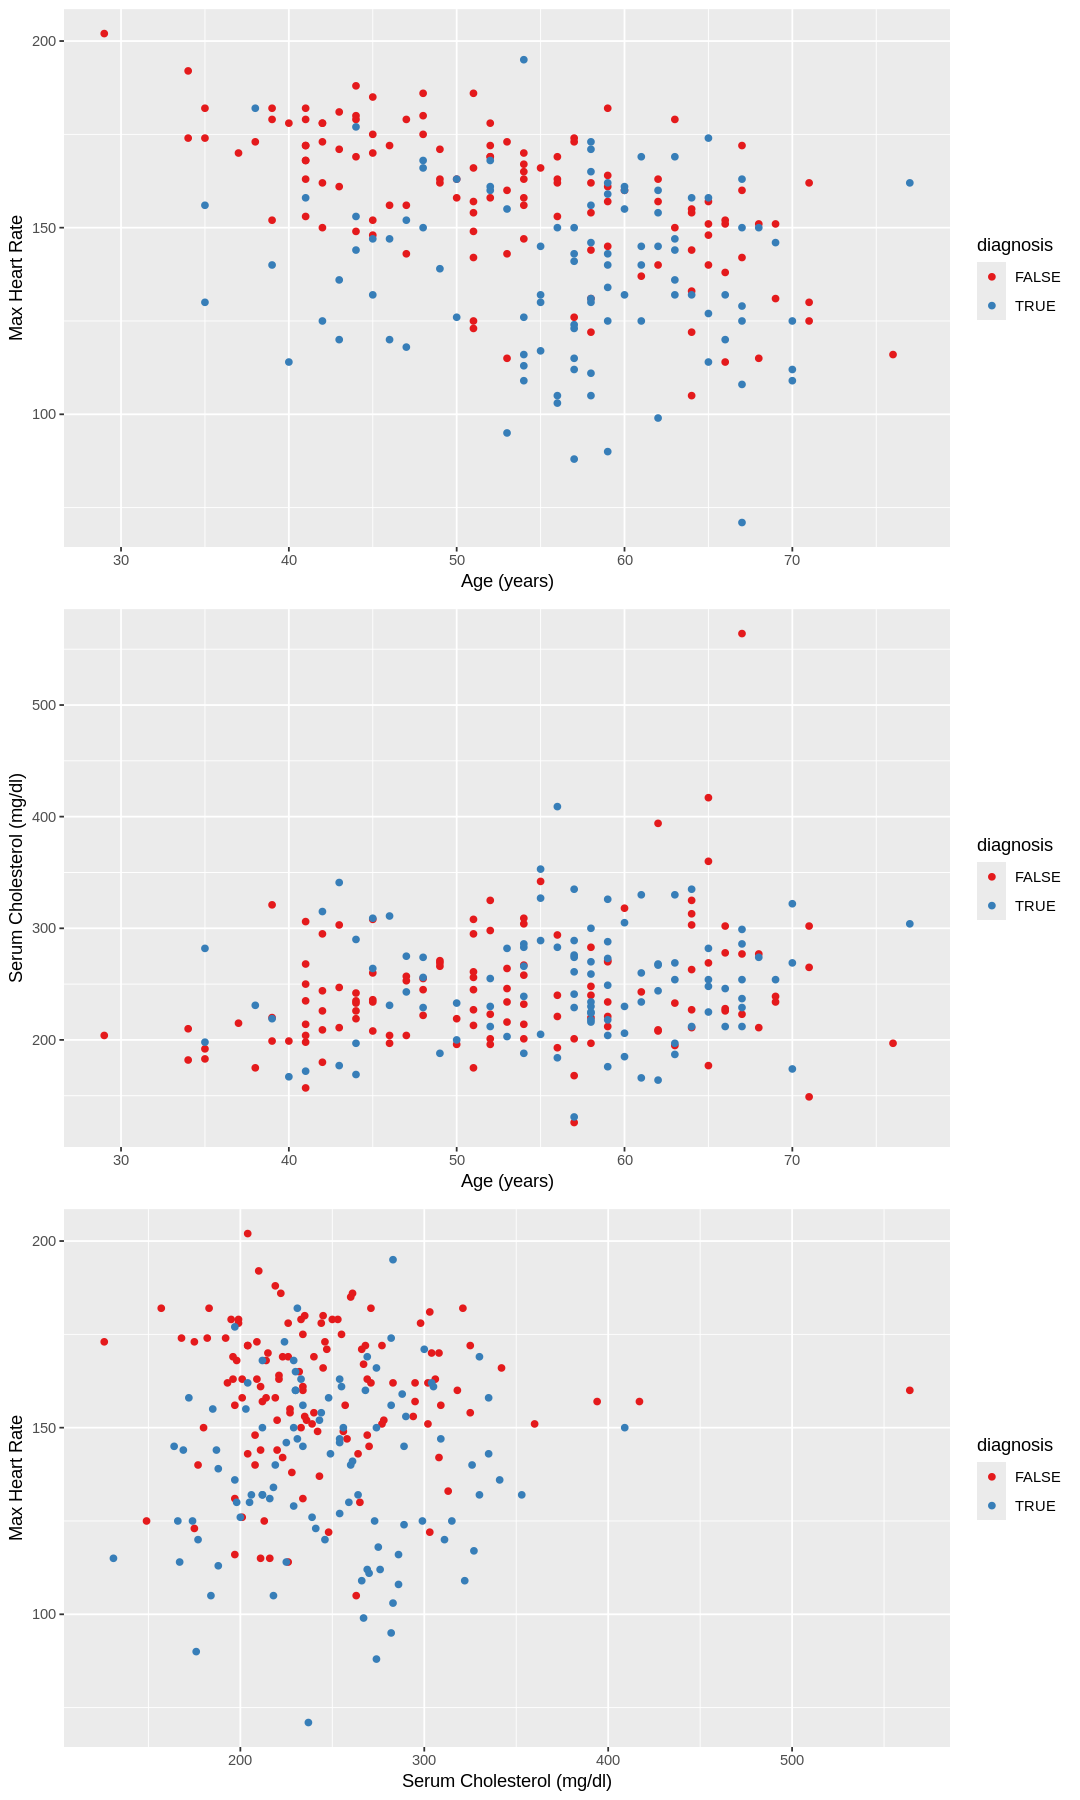

In [93]:
options(repr.plot.width = 9, repr.plot.height = 15)

hr_vs_age <- cleveland_training_data |> 
                ggplot(aes(x = age, y = thalach, color = diagnosis)) +
                 geom_point() +
                 labs(x = "Age (years)", y = "Max Heart Rate", color = "diagnosis") +
                 scale_color_brewer(palette = "Set1")

chol_vs_age <- cleveland_training_data |>
                ggplot(aes(x = age, y = chol, color = diagnosis)) +
                 geom_point() +
                 labs(x = "Age (years)", y = "Serum Cholesterol (mg/dl)", color = "diagnosis") +
                 scale_color_brewer(palette = "Set1")

hr_vs_chol <- cleveland_training_data |>
                ggplot(aes(x = chol, y = thalach, color = diagnosis)) +
                 geom_point() +
                 labs(x = "Serum Cholesterol (mg/dl)", y = "Max Heart Rate", color = "diagnosis") +
                 scale_color_brewer(palette = "Set1")

plots <- plot_grid(hr_vs_age, chol_vs_age, hr_vs_chol,
                ncol = 1, nrow = 3)

plots


### Methods

To classify whether a patient has heart disease based on health measurements, the data will undergo data exploration, data splitting into training and testing sets, model training using the K-nearest-neighbors algorithm, model evaluation, 5-fold cross validation and model optimization. K-values will be tuned to ensure the best selection of the classifier. Finally, the model will be evaluated on against the testing set, and results will be investigated to report on the ability to classify whether a patient has heart disease using the chosen predictor values.

The chosen predictor values are:
- **Age:** in years (age)
- **Serum cholesterol:** in mg/dl (chol)
- **Heart rate:** Maximum heart rate achieved (thalach)
- **Diagnosis of heart disease:** 1,2,3,4 = presence, 0 = no presence (num)

The chosen predictory values have no missing values, as stated from the dataset website.

After reading the dataset from my public Github repository, labels for each column and their data types were created, as they were not provided within the raw data file.

The **num** variable had a range of values from 0 = no prescence of heart disease, to 1,2,3,4 = presence (of increasing levels). To simplify, a new column **diagnosis** of type boolean was created, where TRUE represents presence and FALSE represents no presence.

The dataframe was then split into 75% training and 25% testing by using the initial_split function, while indicating our **diagnosis** as the strata.

To summarize the training data, we grouped by **diagnosis**, then summarized by mean for **age, chol, thalach**.

As for visualizations, scatterplots for each predictor will be plotted against each other to visualize any clusters or patterns. Observations classified as TRUE will appear blue, whereas FALSE appears red.

### Expected Outcomes and Significance

#### Expected Findings
Overall, we expect that patients with heart disease have a higher age, higher cholesterol levels, and lower heart rates. This project will allow us to find important indications of heart disease in potential patients.

#### Potential Impacts

It is unclear as to whether the sampling pool was taken at random, or if there were related family members as well. Genetic factors could be an underlying cause in the dataset.

#### Future Questions

- Can we use a different classification algorithm to classify for heart patients, such as **K-means Clustering**?
- Are there methods or tests to determine heart disease at a younger age?

### Bibliography

What is cardiovascular disease?. www.heart.org. (2024, June 5). https://www.heart.org/en/health-topics/consumer-healthcare/what-is-cardiovascular-disease 

Managing cholesterol. Heart and Stroke Foundation of Canada. (n.d.). https://www.heartandstroke.ca/heart-disease/risk-and-prevention/condition-risk-factors/managing-cholesterol 

Zhang, D., Wang, W., & Li, F. (2016). Association between resting heart rate and coronary artery disease, stroke, sudden death and noncardiovascular diseases: A meta-analysis. Canadian Medical Association Journal, 188(15). https://doi.org/10.1503/cmaj.160050 